# ASCAD analysis

## Using hamming weights as key distance measure

For a masked implementation of AES, the XOR operations at the end of the SBox cause the leakage [1].
Splitting the traces in the ASCAD database based on the hamming weight of the state after the SBox operation should
therefore expose this leakage.

[1] Pinpointing the Side-Channel Leakage of Masked AES Hardware Implementations. Mangard S & Schramm K. 2016

### Hamming weight of 1st state byte.

1st order moment difference.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import stats

In [ ]:
from src.data.slices import random_slice
from src.data.traceloader import AscadRandomKey
from src.data.traceloader import TraceCategory
from src.tools.plotter import shadow_plot
from src.tools.poi import select_poi

In [18]:
sns.set_style("whitegrid")

In [19]:
ascad = AscadRandomKey()
profile = ascad.default.profile

array([  767,  6221, 22065, 43838, 54996, 43662, 21538,  6129,   784])

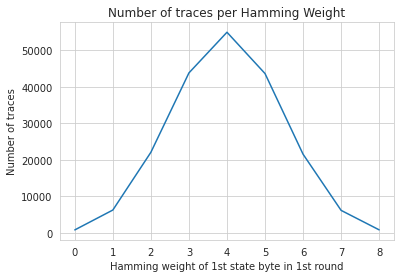

In [20]:
bc = np.bincount(profile.hamming_weights[:,0,0])
sns.lineplot(data=bc).set(title="Number of traces per Hamming Weight",
                          xlabel="Hamming weight of 1st state byte in 1st round",
                          ylabel="Number of traces")

bc

In [21]:

def statistical_moment(traces: np.array, moment=1):
    """
    Retrieves a statistical moment in a given order for a given set of traces.
    The moment
    """
    if moment == 1:
        return traces.mean(axis=0)
    if moment == 2:
        return traces.var(axis=0)
    if moment == 3:
        return stats.skew(traces, axis=0)
    if moment == 4:
        return stats.kurtosis(traces, axis=0)

    raise Exception("Moment not implemented.")


def calc_moment_difference(left_1, left_2, right, moment=1):
    """
    Calculates the difference in statistical moment between power traces with
    equal keys and power traces with different keys.
    """

    def smt(a):
        return statistical_moment(a, moment)

    dist_neq = abs(smt(left_1) - smt(right))
    dist_eq = abs(smt(left_1) - smt(left_2))

    return dist_neq - dist_eq


def hw_mdiff(tc: TraceCategory, trace_size=ascad.trace_len, max_moment=3):
    """
    Calculates the difference in statistical moment between power traces with
    equal keys and power traces with different keys, up to a given order of
    statistical moment.
    """
    selected_hw = 2
    mdiff = np.zeros((max_moment + 1, trace_size))
    for stat_moment in range(1, max_moment + 1):
        hw0_left, hw0_right = random_slice(tc.filter_by_hw(True), 2)
        high = tc.filter_by_hw(False)

        mdiff[stat_moment] = calc_moment_difference(hw0_left, hw0_right, high, stat_moment)

    return mdiff

In [22]:
def plot_poi(mdiff, moment):
    """
    Plots moment difference with points of interest.
    """
    fig, ax = plt.subplots()

    title = f"Difference in statistical moment ({moment})\n Points of Interest are highlighted.\n"
    sns.lineplot(data=mdiff[moment]).set_title(title)

    for a, b in select_poi(mdiff[moment]):
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()


def plot_poi_trace(trace, poi):
    """
    Plots power trace with points of interest.
    """
    fig, ax = plt.subplots()

    title = f"Some power trace, Points of Interest from\nstatistical moment (1) are highlighted.\n"
    sns.lineplot(data=trace, palette=[sns.color_palette()[4]]).set_title(title)

    for a, b in poi:
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()

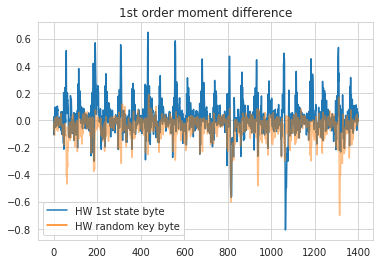

(0.017640540525507592, -0.06215592961820965)

In [23]:
mdiff_default = hw_mdiff(ascad.default.profile, ascad.trace_len)
mdiff_random = hw_mdiff(ascad.random.profile, ascad.trace_len)

shadow_plot({"HW 1st state byte": mdiff_default[1], "HW random key byte": mdiff_random[1]}, title="1st order moment difference")

mdiff_default[1].mean(), mdiff_random[1].mean()

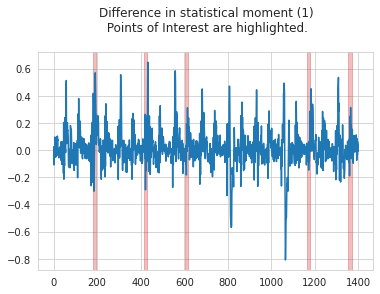

In [24]:
plot_poi(mdiff_default, 1)

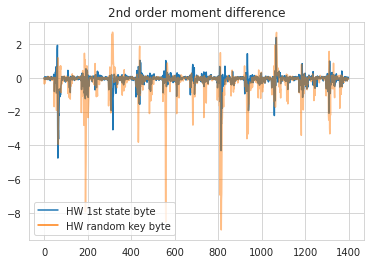

In [25]:
shadow_plot({"HW 1st state byte": mdiff_default[2], "HW random key byte": mdiff_random[2]}, title="2nd order moment difference")

In [1]:
shadow_plot({"HW 1st state byte": mdiff_default[3], "HW random key byte": mdiff_random[3]}, title="3rd order moment difference")


NameError: name 'shadow_plot' is not defined